[7.78888087e-01 9.54425090e-02 4.98503284e-02 2.04777732e-02
 1.49285483e-02 9.85727890e-03 8.98040319e-03 6.95825205e-03
 5.10089810e-03 2.68913637e-03 2.28994350e-03 1.87191942e-03
 1.17618265e-03 7.27488675e-04 3.90277226e-04 2.61085787e-04]


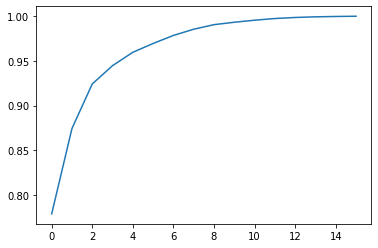

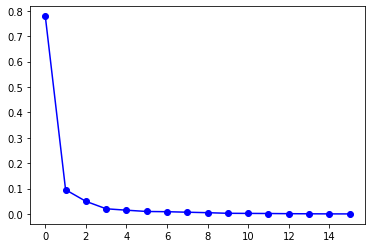

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVR]
    fold  0:  [0.01558034]
    fold  1:  [0.01812071]
    fold  2:  [0.11041626]
    fold  3:  [0.08263992]
    ----
    MEAN:     [0.05668931] + [0.04104115]
    FULL:     [0.05433016]

model  1:     [RandomForestRegressor]


C:\Users\ICT01_18\Anaconda3\lib\site-packages\vecstack\core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


    fold  0:  [0.01298431]
    fold  1:  [0.01857474]
    fold  2:  [0.13505971]
    fold  3:  [0.05733169]
    ----
    MEAN:     [0.05598761] + [0.04874220]
    FULL:     [0.05586542]

model  2:     [XGBRegressor]
    fold  0:  [0.01772556]
    fold  1:  [0.02254307]
    fold  2:  [0.07897356]
    fold  3:  [0.12703457]
    ----
    MEAN:     [0.06156919] + [0.04481610]
    FULL:     [0.05561779]

X_train MSE :  0.04191245777650536
X_test MSE :  0.0382798313825054


,y_test,y_preds
y_test,1.000000,0.868405
y_preds,0.868405,1.000000


In [72]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking 
from sklearn.svm import SVR
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load demo data 
data = pd.read_csv('team2.csv', index_col=0)
X, y = data.iloc[:,1:],  data.iloc[:,0]

minmax_X = minmax_scale(X)
minmax_Y = minmax_scale(y)

pca = PCA(n_components=16)
model = pca.fit_transform(minmax_X)
print(pca.explained_variance_ratio_) # 설명력
plt.plot(np.cumsum(pca.explained_variance_ratio_)) # elbow를 시각적으로 확인
plt.show()
plt.plot(pca.explained_variance_ratio_, 'bo-')
plt.show()
pca.explained_variance_ratio_

princ = pd.DataFrame(data=model[:,:3], columns=range(0,3))
princ

X_train, X_test, y_train, y_test = train_test_split(princ,minmax_Y,test_size = 0.4, random_state=0)

# Make train/test split 
# As usual in machine learning task we have X_train, y_train, and X_test 
# X_train, X_test, y_train, y_test = train_test_split(minmax_X, minmax_Y, test_size = 0.4, random_state = 0) 

# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended. 
# Initialize 1-st level models. 
models = [ SVR(gamma='scale'), 
          RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3), 
          XGBRegressor(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3,silent=True)] 

# Compute stacking features 
S_train, S_test = stacking(models, X_train, y_train, X_test, regression = True, 
                           metric = mean_squared_error, n_folds = 4, stratified = True, shuffle = True, random_state = 0, verbose = 2) 

# Initialize 2-nd level model 
model = SVR(gamma ='auto')

# Fit 2-nd level model 
model = model.fit(S_train, y_train) 
 

X_pred=model.predict(S_train)
print('X_train MSE : ', mean_squared_error(y_train, X_pred))
y_pred = model.predict(S_test)
print("X_test MSE : ",mean_squared_error(y_test, y_pred))


df1 = pd.DataFrame({'y_test':y_test, 'y_preds':y_pred})
df1.corr()

In [73]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [74]:
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10,100], 
           'gamma':[0.001,0.01,0.1,1,10,100]}

clf = GridSearchCV(model, param_grid, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'C': 1, 'gamma': 0.001}


C:\Users\ICT01_18\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [75]:
X_pred2 = clf.predict(S_train)
print('X_train MSE : ', mean_squared_error(y_train, X_pred2))
y_pred2 = clf.predict(S_test)
print("X_test MSE : ",mean_squared_error(y_test, y_pred2))

df2 = pd.DataFrame({'y_test':y_test, 'y_preds':y_pred2})
df2.corr()

X_train MSE :  0.044875154280001966
X_test MSE :  0.041774635823563555


,y_test,y_preds
y_test,1.000000,-0.926344
y_preds,-0.926344,1.000000
